In [13]:
import requests
import json
import numpy as np
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pydeck

In [20]:
import ipywidgets as widgets
from IPython.display import display, HTML

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]

def hide_button():
    state = False
    toggle_code(state)
    button = widgets.ToggleButton(state, description = button_descriptions[state])
    button.observe(button_action, "value")
    display(button)
    hide_button()

# Load data and data preprocessing

In [2]:
def load_data():
    params = {'format' : 'json'}
    headers = headers = {
        'x-rapidapi-key': "6b39c0e054msh48c6c356e0b467ep1c76e5jsn6e7244e9217e",
        'x-rapidapi-host': "covid-19-coronavirus-statistics.p.rapidapi.com"
        }
    reponse = requests.get(f"https://covid-19-coronavirus-statistics.p.rapidapi.com/v1/stats"
                            ,headers=headers,params=params)
    data = reponse.json()
    data_c = data['data']['covid19Stats']
    df = pd.DataFrame(data_c)
    return df

In [3]:
def data_preprocessing():
    df = load_data()
    df = df.drop(['city','province'],axis=1)
    df = df.rename(columns={'lastUpdate' : 'date/time'})
    df['date/time'] = pd.to_datetime(df['date/time']).dt.tz_localize(None)
    df.replace({'country' : {'Taiwan*' : 'Taiwan'}},inplace=True)
    df.loc[df['keyId'] == 'Hong Kong, China','country'] = 'Hong Kong'
    df.loc[df['keyId'] == 'French Guiana, France','country'] = 'French Guiana'
    df.loc[df['keyId'] == 'French Polynesia, France','country'] = 'French Polynesia'
    date_arr = np.unique(df['date/time'])
    date = date_arr[len(date_arr) - 1]
    df.drop(df[df['date/time'] != date].index,inplace=True)
    df.drop(['date/time','keyId'],axis=1,inplace=True)
    return df

In [4]:
def load_data_country():
    df_countries = pd.read_csv('country.txt')
    df_countries.rename(columns={'Country' : 'country'},inplace=True)
    name_of_country = {'Brunei Darussalam' : 'Brunei', 'Cape Verde' :'Cabo Verde','Czech Republic': 'Czechia',
                  'Congo':'Congo (Brazzaville)', 'Congo, The Democratic Republic of the': 'Congo (Kinshasa)',
                  'Holy See (Vatican City State)' : 'Holy See','Iran, Islamic Republic of': 'Iran' ,'Korea, Republic of':
                   'Korea, South','Lao People\'s Democratic Republic' : 'Laos', 'Libyan Arab Jamahiriya' : 'Libya',
                  'Moldova, Republic of' : 'Moldova','Macedonia' : 'North Macedonia','Russian Federation' : 'Rusia',
                  'Syrian Arab Republic':'Syria','United States' :'US' }
    df_countries.replace({'country' : name_of_country},inplace=True)
    return df_countries

In [5]:
def load_data_vaccine():
    url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/vaccine_data_global.csv'
    data_vac = pd.read_csv(url)
    data_vac.drop(columns=['Date','Report_Date_String','UID'],inplace=True)
    return data_vac

In [6]:
def covid_by_country_regions(dataFrame, name_of_country):
    return dataFrame[dataFrame['country'] == name_of_country]\
            .sort_values(by=['confirmed'],ascending=False).head(5)

In [7]:
def covid_group(dataFrame):
    df_gr = dataFrame.groupby(['country'])\
              .agg({'confirmed' : 'sum','deaths':'sum','recovered':'sum'})\
              .reset_index()
    df_gr.replace(np.NaN,0,inplace=True)
    df_region = pd.read_csv('region.csv',sep=';')
    df_gr = pd.merge(df_gr,df_region,on='country',how='left')
    return df_gr

In [8]:
def covid_all(dataFrame,df_country):
    df_all = pd.merge(dataFrame,df_countries,on='country',how='left')
    return df_all

# Interactive data and visualize

In [9]:
dataFrame = data_preprocessing()

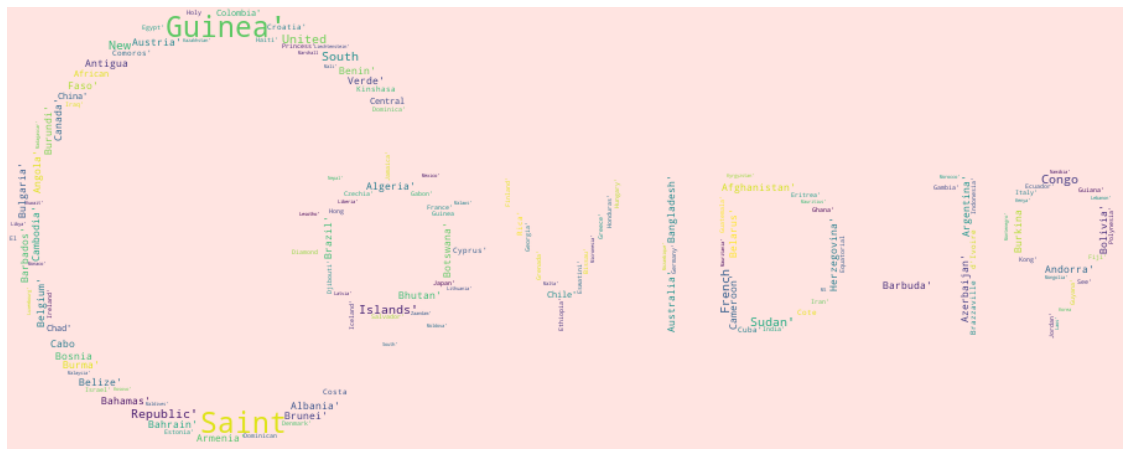

In [21]:
def covid_banner_worldcloud(dataFrame):
    mask = np.array(Image.open('covid19_logo.png'))
    df_gr = covid_group(dataFrame)
    country = df_gr['country'].values
    wordcloud_cv = WordCloud(background_color="mistyrose", mode="RGB", max_words=195, mask=mask).generate(str(country))
    plt.figure(figsize=[20,15])
    plt.imshow(wordcloud_cv,interpolation="bilinear")#.recolor(color_func=image_colors))
    plt.axis("off")
    plt.show()
covid_banner_worldcloud(dataFrame)
hide_toggle()

### Case
##### Around the world

In [22]:
df_total = dataFrame.sum(axis=0).to_frame()
df_total = df_total.transpose()
df_total.drop(['country'],axis=1,inplace=True)
display(df_total)
hide_toggle()

,confirmed,deaths,recovered
0,147548534,3117617,85313570.0


In [12]:
country = input('Enter name of country: ')
df_by_ct = covid_by_country_regions(dataFrame,country)
df_by_ct.head()

Enter name of country: Vietnam


,country,confirmed,deaths,recovered
3978,Vietnam,2852,35,2516.0
